In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("rstan")

In [ ]:
%%R
library("rstan")


rstan version 2.32.6 (Stan version 2.32.2)


options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




## Baseline

## Assumption here is that all `guideID`s are functional

In [ ]:
%%R
# Load data
dat <- read.csv("./data1.txt", header = T, sep = '\t')

# Subset
dat <- dat[dat$gene %in% c(1:10),]
print(nrow(dat))

# Create a binary indicator for control samples (1 if enhancerID or guideID == -1, 0 otherwise)
dat$is_control <- ifelse(dat$enhancerID == -1 | dat$guideID == -1, 1, 0)

## Indicate control data
y_control <- dat[dat$is_control == 1,]$expression
y_experiment <- dat[dat$is_control == 0,]$expression

# Make sure we have the variables factored, then converted to integer representations
for (nm in colnames(dat)[colnames(dat) != "expression"]) dat[[nm]] <- as.integer(as.factor(dat[[nm]]))

# Prepare data for Stan
stan_data <- list(
  N = nrow(dat),
  X = dat$expression,
  gene = dat$geneID,
  enhancer = dat$enhancerID,
  guideID = dat$guideID,
  G = length(unique(dat$guideID)),  # Number of unique guides
  E = length(unique(dat$enhancerID)),
  NGENE = length(unique(dat$geneID)),
  is_control = dat$is_control,
  y_control = y_control,
  NCONTROL = length(y_control),
  NEXPERIMENT = length(y_experiment),
  y_experiment = y_experiment
)

stan_code <- "
data {
    int<lower=0> N;                        // Total number of observations
    int<lower=0> NCONTROL;                 // Number of control samples
    int<lower=0> NEXPERIMENT;              // Number of experiment samples
    int<lower=1> NGENE;                    // Number of unique genes
    real X[N];                             // expression data
    int<lower=0> enhancer[N];              // Index for enhancer
    int<lower=0> is_control[N];            // Indicator for control samples
    int<lower=0> y_control[NCONTROL];             // Control samples
    int<lower=0> y_experiment[NEXPERIMENT];          // Experiment samples
    int<lower=0> E; //Enhancer ID
}

transformed data {
  real<lower=0> mu_control_observed = mean(y_control);            // Empirical mean of y_control
  real<lower=0> sigma_control_observed = sd(y_control);           // Empirical standard deviation of y_control
  real<lower=0> mu_experiment_observed = mean(y_experiment);      // Empirical mean of y_experiment
  real<lower=0> sigma_experiment_observed = sd(y_experiment);     // Empirical standard deviation of y_experiment
  real beta_observed = mu_experiment_observed / mu_control_observed;  // Empirical effect size
}

parameters {
    vector<lower=0, upper=1>[E] beta; //Beta for each enhancer
}

model {
    // Priors
    beta ~ beta(2, 2);  // Beta distribution prior

    // Likelihood
    for (i in 1:N) {
        if (is_control[i] == 2) {
            X[i] ~ normal(mu_control_observed, sigma_control_observed);
        } else {
            X[i] ~ normal(mu_control_observed*beta[enhancer[i]], sigma_experiment_observed);
        }
    }
}

generated quantities {
    real X_pred[N];  // Predicted expression values for each observation
    for (i in 1:N) {
        if (is_control[i] == 2) {
            X_pred[i] = normal_rng(mu_control_observed, sigma_control_observed);
        } else {
            X_pred[i] = normal_rng(mu_control_observed * beta[enhancer[i]], sigma_experiment_observed);
        }
    }
}

"

# Compile and fit the model
fit <- stan(
  model_code = stan_code,
  data = stan_data,
  iter = 1000,
  warmup = 250,
  seed = 1337,
  chains = 4,
  diagnostic_file = "BASELINE_diagnostics.csv"
)

[1] 7800

SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001606 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 16.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 251 / 1000 [ 25%]  (Sampling)
Chain 1: Iteration: 350 / 1000 [ 35%]  (Sampling)
Chain 1: Iteration: 450 / 1000 [ 45%]  (Sampling)
Chain 1: Iteration: 550 / 1000 [ 55%]  (Sampling)
Chain 1: Iteration: 650 / 1000 [ 65%]  (Sampling)
Chain 1: Iteration: 750 / 1000 [ 75%]  (Sampling)
Chain 1: Iteration: 850 / 1000 [ 85%]  (Sampling)
Chain 1: Iteration: 950 / 1000 [ 95%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.959 seconds (Warm-up)
Chain 1:                15.177 seconds (Sampling)
Chain 1:             

In [ ]:
%%R
# Summary statistics for beta coefficients
print(fit, pars = c("beta"), probs = c(0.025, 0.5, 0.975))

Inference for Stan model: anon_model.
4 chains, each with iter=1000; warmup=250; thin=1; 
post-warmup draws per chain=750, total post-warmup draws=3000.

          mean se_mean   sd 2.5%  50% 97.5% n_eff Rhat
beta[1]   0.50       0 0.22 0.11 0.50  0.90  4256    1
beta[2]   0.77       0 0.05 0.68 0.77  0.86  4475    1
beta[3]   0.77       0 0.05 0.68 0.78  0.86  4047    1
beta[4]   0.64       0 0.05 0.53 0.63  0.74  3998    1
beta[5]   0.74       0 0.05 0.65 0.74  0.84  3948    1
beta[6]   0.50       0 0.05 0.40 0.50  0.59  4824    1
beta[7]   0.99       0 0.00 0.98 0.99  1.00  4493    1
beta[8]   0.95       0 0.03 0.89 0.96  0.99  3906    1
beta[9]   0.99       0 0.00 0.98 0.99  1.00  5226    1
beta[10]  0.99       0 0.01 0.97 0.99  1.00  4935    1
beta[11]  0.98       0 0.01 0.95 0.98  1.00  4935    1
beta[12]  0.99       0 0.01 0.97 0.99  1.00  3636    1
beta[13]  0.99       0 0.00 0.98 0.99  1.00  4743    1
beta[14]  0.99       0 0.00 0.98 1.00  1.00  5216    1
beta[15]  0.99       

In [ ]:
%%R
check_hmc_diagnostics(fit)


Divergences:



Tree depth:



Energy:


Saving 6.67 x 6.67 in image


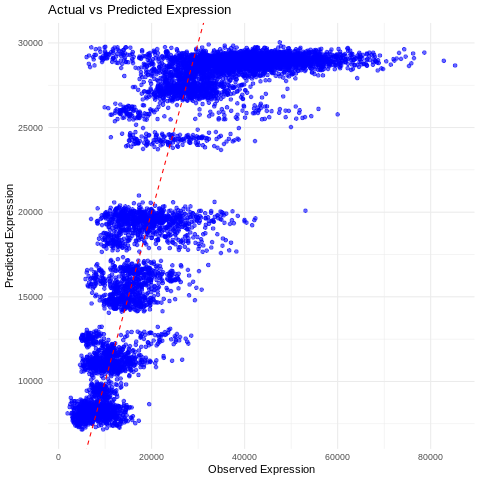

In [ ]:
%%R
# Extract predicted samples (posterior predictive)
posterior_predictive <- extract(fit, pars = "X_pred")$X_pred

# Compute the mean of posterior predictive samples for each observation
predicted_mean <- apply(posterior_predictive, 2, mean)

plot_data <- data.frame(
  observed = dat$expression,
  predicted = predicted_mean
)

write.csv(plot_data, "BASELINE_expression.csv", row.names = FALSE)

library(ggplot2)

plot_to_save <- ggplot(plot_data, aes(x = observed, y = predicted)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(
    title = "Actual vs Predicted Expression",
    x = "Observed Expression",
    y = "Predicted Expression"
  ) + theme_minimal()

ggsave(plot_to_save, file = "BASELINE_expression.png")
plot_to_save

In [ ]:
%%R
summary(plot_data)

    observed       predicted    
 Min.   :  281   Min.   : 1117  
 1st Qu.: 9729   1st Qu.:10499  
 Median :20796   Median :22080  
 Mean   :23095   Mean   :18006  
 3rd Qu.:34367   3rd Qu.:24893  
 Max.   :91729   Max.   :26463  


In [ ]:
%%R
# Extract the posterior samples for beta
beta_samples <- extract(fit, pars = "beta")$beta

beta_mean <- apply(beta_samples, 2, mean)

beta_df <- data.frame(
  enhancerID = 1:length(beta_mean),  # Enhancer IDs (assuming 1-based indexing in Stan)
  beta_mean = beta_mean
)

# Merge beta coefficients with the original dataset
dat_beta <- merge(dat, beta_df, by.x = "enhancerID", by.y = "enhancerID", all.x = TRUE)

true_betas <- read.csv("./final/true-betas1.txt", header = T, sep = '\t')

results <- merge(dat_beta, true_betas, by = c("geneID", "enhancerID"), all.x = TRUE)

# Subset what we need
results <- results[,c("geneID", "enhancerID", "beta_mean", "beta")]
# Drop duplicate observations
results <- results[!duplicated(results),]

# Remove NAs
results <- na.omit(results)

write.csv(results, file = "BASELINE_beta.csv", row.names = F)

# Mean Squared Error
mse <- mean((results$beta - results$beta_mean)^2)

# Mean Absolute Error
mae <- mean(abs(results$beta - results$beta_mean))

cat("Mean Squared Error (MSE):", mse, "\n")
cat("Mean Absolute Error (MAE):", mae, "\n")

plot_to_save <- ggplot(results, aes(x = beta, y = beta_mean)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(
    title = "Actual vs Predicted Beta Values",
    x = "True Beta Values",
    y = "Predicted Beta Values"
  ) +
  theme_minimal() + ylim(c(0, 1)) + xlim(c(0, 1))

ggsave(plot_to_save, file = "BASELINE_beta.png")
plot_to_save

Mean Squared Error (MSE): 0.09902503 
Mean Absolute Error (MAE): 0.2450437 
